# GANs with Hands

We will build a Generative Adversarial Network (GAN) that generates pictures of hands. These will be trained on a dataset of hand images doing sign language.

### Imports

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
tf.config.run_functions_eagerly(True)

import matplotlib.pyplot as plt
import numpy as np

import urllib.request
import zipfile
from IPython import display

### Utilities

In [2]:
def plot_results(images, n_cols=None):
    '''visualizes fake images'''
    display.clear_output(wait=False)  
    
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    
    plt.figure(figsize=(n_cols, n_rows))
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

### Get the training data

You will download the dataset and extract it to a directory in your workspace. As mentioned, these are images of human hands performing sign language.

In [3]:
# download the dataset
# training_url = "https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/signs-training.zip"
training_file_name = "signs-training.zip"
# urllib.request.urlretrieve(training_url, training_file_name)

# extract to local directory
training_dir = "/tmp"
zip_ref = zipfile.ZipFile(training_file_name, 'r')
zip_ref.extractall(training_dir)
zip_ref.close()

###  Preprocess the images

Next, you will prepare the dataset to a format suitable for the model. You will read the files, convert it to a tensor of floats, then normalize the pixel values.

In [4]:
BATCH_SIZE = 32

def map_images(file):
    '''converts the images to floats and normalizes the pixel values'''
    img = tf.io.decode_png(tf.io.read_file(file))
    img = tf.cast(img, tf.float32)
    img = img / 255.0
    
    return img

file_name = tf.data.Dataset.list_files('/tmp/signs-training/*.png')
image_dataset = file_name.map(map_images).batch(BATCH_SIZE)

C:\Users\Ahmad Ansari\anaconda3\envs\tf_env\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


### Build the generator

In [5]:
random_normal_dimensions = 32

generator = keras.models.Sequential([
    keras.layers.Input(shape=[random_normal_dimensions]),
    keras.layers.Dense(units=(7 * 7 * 28)),
    keras.layers.Reshape([7, 7, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(filters=64, strides=2, kernel_size=5, padding='same', activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(filters=1, strides=2, kernel_size=5, padding='same', activation='tanh')
])

### Build the discriminator

In [6]:
discriminator = keras.models.Sequential([
    keras.layers.Input(shape=(28,28,1,)),
    keras.layers.Conv2D(filters=64, strides=2, kernel_size=5, padding='same', activation='leaky_relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(filters=128, strides=2, kernel_size=5, padding='same', activation='leaky_relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

### Compile the discriminator

- Set the discriminator to not train on its weights (set its "trainable" field).

In [7]:
discriminator.compile(optimizer='rmsprop', loss='binary_crossentropy')
discriminator.trainable = False

In [8]:
gan = keras.models.Sequential([generator, discriminator])
gan.compile(optimizer='rmsprop', loss='binary_crossentropy')

## Build and compile the GAN model

- Build the sequential model for the GAN, passing a list containing the generator and discriminator.

### Train the GAN

In [9]:
@tf.function
def train_gan(gan, dataset, random_normal_dimensions, n_epochs=50):
    """ Defines the two-phase training loop of the GAN
    Args:
    gan -- the GAN model which has the generator and discriminator
    dataset -- the training set of real images
    random_normal_dimensions -- dimensionality of the input to the generator
    n_epochs -- number of epochs
    """
    generator, discriminator = gan.layers
    
    for epoch in range(n_epochs):
        print('Epoch {}/{}'.format(epoch + 1, n_epochs))
        
        for real_images in dataset:
            
            real_batch_size = real_images.shape[0]
            
            noise = tf.random.normal(shape=[real_batch_size, random_normal_dimensions])

            fake_images = generator(noise)
            
            mixed_images = tf.concat([real_images, fake_images], axis=0)
            
            discriminator_labels = tf.constant([[1.]] * real_batch_size + [[0.]] * real_batch_size)
            
            discriminator.trainable = True
            
            discriminator.train_on_batch(mixed_images, discriminator_labels)
            
            noise = tf.random.normal(shape=[real_batch_size, random_normal_dimensions])
            
            generator_labels = tf.constant([[1.]] * real_batch_size)
            
            discriminator.trainable = False
            
            gan.train_on_batch(noise, generator_labels)
            
        plot_results(fake_images)
        plt.show()
        
    return fake_images

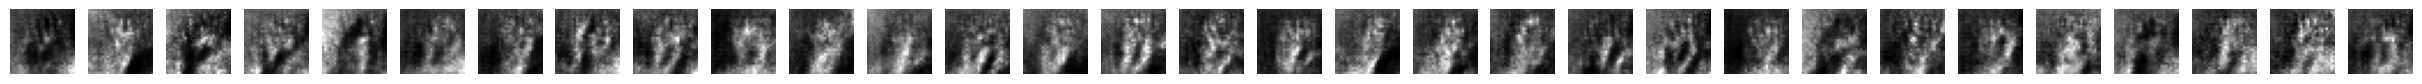

In [10]:
# you can adjust the number of epochs
EPOCHS = 1

# run the training loop and collect images
fake_images = train_gan(gan, image_dataset, random_normal_dimensions, EPOCHS)